In [11]:
import importlib
from glob import glob
from pathlib import Path

import numpy as np
import pandas as pd
from tqdm import tqdm

from bfm_finetune import plots_v2 
from bfm_finetune.utils import (
    aggregate_into_latlon_grid,
    get_lat_lon_ranges,
    unroll_matrix_into_df,
)

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
finetune_location = Path(
    "/projects/prjs1134/data/projects/biodt/storage/finetune"
 )  # snellius
#finetune_location = Path("../data/finetune")  # local
geolifeclef_location = finetune_location / "geolifeclef24"

# https://lab.plantnet.org/seafile/d/bdb829337aa44a9489f6/files/?p=%2FPresenceAbsenceSurveys%2FReadMe.txt
# presence-absence: in europe
pa_path = geolifeclef_location / "GLC24_PA_metadata_train.csv"

In [3]:
df = pd.read_csv(pa_path)
# 1483637
print(len(df))
# ['lon', 'lat', 'year', 'geoUncertaintyInM', 'areaInM2', 'region', 'country', 'speciesId', 'surveyId']
print(df.columns)
df["speciesId"].unique()  # 5016 species
df["surveyId"].unique()  # 88987 different surveys

# one survey:
df[df["surveyId"] == 212]
# 15 rows (15 different species are present, the other ones are absent?)

# one species?
df[df["speciesId"] == 6874.0]  # 924 rows: indicating where it appears (no time filter)

1483637
Index(['lon', 'lat', 'year', 'geoUncertaintyInM', 'areaInM2', 'region',
       'country', 'speciesId', 'surveyId'],
      dtype='object')


,lon,lat,year,geoUncertaintyInM,areaInM2,region,country,speciesId,surveyId
0,3.099038,43.134956,2021,5.0,100.0,MEDITERRANEAN,France,6874.0,212
2780,4.177610,43.848390,2017,1.0,NaN,MEDITERRANEAN,France,6874.0,7950
3112,15.485710,42.110800,2020,1.0,100.0,MEDITERRANEAN,Italy,6874.0,8669
3554,2.339040,43.145010,2018,1.0,NaN,MEDITERRANEAN,France,6874.0,9576
4185,5.486416,43.204942,2019,10.0,40.0,MEDITERRANEAN,France,6874.0,11039
...,...,...,...,...,...,...,...,...,...
1471906,3.144531,43.194955,2021,5.0,100.0,MEDITERRANEAN,France,6874.0,3888731
1471946,9.374250,40.938296,2018,10.0,200.0,MEDITERRANEAN,Italy,6874.0,3888840
1476908,5.672178,43.214294,2021,10.0,200.0,MEDITERRANEAN,France,6874.0,3902672
1478750,2.878387,43.047919,2021,5.0,50.0,MEDITERRANEAN,France,6874.0,3907609


In [4]:
step = 0.25
lat_range, lon_range = get_lat_lon_ranges(lat_step=step, lon_step=step)

In [5]:
df500 = df.groupby(['speciesId', 'year', 'lon','lat']).size().reset_index()
df500.head()

,speciesId,year,lon,lat,0
0,2.0,2017,1.963972,42.743200,1
1,2.0,2017,1.964000,42.743194,1
2,2.0,2017,1.973056,42.863889,1
3,2.0,2017,3.170130,44.616140,1
4,2.0,2018,0.129650,46.361030,1


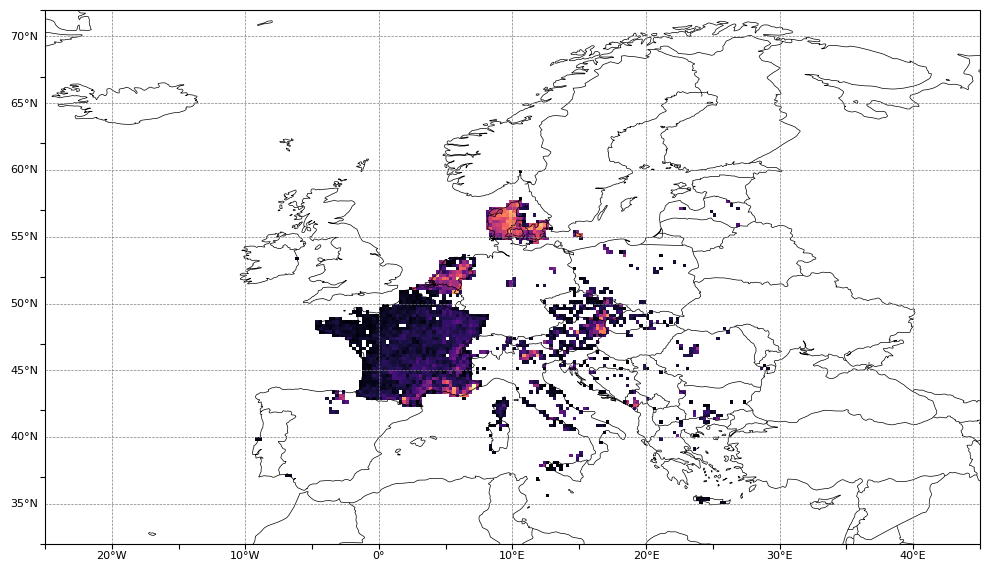

In [12]:
# Set new extent and grid
extent = (-25.0, 45.0, 32.0, 72.0)   # lon_min, lon_max, lat_min, lat_max
ddeg = 0.25

lon_edges = np.arange(extent[0], extent[1] + ddeg, ddeg)  # 281 edges, 280 cells
lat_edges = np.arange(extent[2], extent[3] + ddeg, ddeg)  # 161 edges, 160 cells
n_x, n_y = len(lon_edges) - 1, len(lat_edges) - 1         # n_x=280, n_y=160

# Compute richness per cell
lon_idx = np.searchsorted(lon_edges, df["lon"], side="right") - 1
lat_idx = np.searchsorted(lat_edges, df["lat"], side="right") - 1
inside = (lon_idx >= 0) & (lon_idx < n_x) & (lat_idx >= 0) & (lat_idx < n_y)

cell_key = lat_idx[inside] * n_x + lon_idx[inside]
richness = (
  pd.DataFrame({"cell": cell_key, "sp": df["speciesId"].values[inside]})
    .drop_duplicates()
    .groupby("cell").size()
    .reindex(range(n_x * n_y), fill_value=0)
    .values.reshape(n_y, n_x)
)

# Colormap and mask
cmap = plt.cm.magma.copy()
cmap.set_under("white")
rich_mask = np.ma.masked_where(richness == 0, richness)

# Plot
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=proj))

ax.pcolormesh(lon_edges, lat_edges, rich_mask,
        cmap=cmap, vmin=1, shading="auto", transform=proj)

ax.set_extent(extent, crs=proj)
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.BORDERS, linewidth=0.5)

gl = ax.gridlines(draw_labels=True, linewidth=.5, color="gray", linestyle="--")
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = gl.ylabel_style = {'size': 8}

ax.set_xticks(np.arange(-25, 46, 5), crs=proj)
ax.set_yticks(np.arange(32, 73, 5), crs=proj)
ax.tick_params(axis="x", labelbottom=False, labeltop=False)
ax.tick_params(axis="y", labelleft=False, labelright=False)

fig.tight_layout()
fig.savefig("species_richness_025deg_32-72N_-25-45E.png", dpi=300, bbox_inches="tight")
plt.show()


/scratch-local/72884/ipykernel_1038242/1039600842.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred_tensor = torch.load(pred_path, map_location="cpu")
/scratch-local/

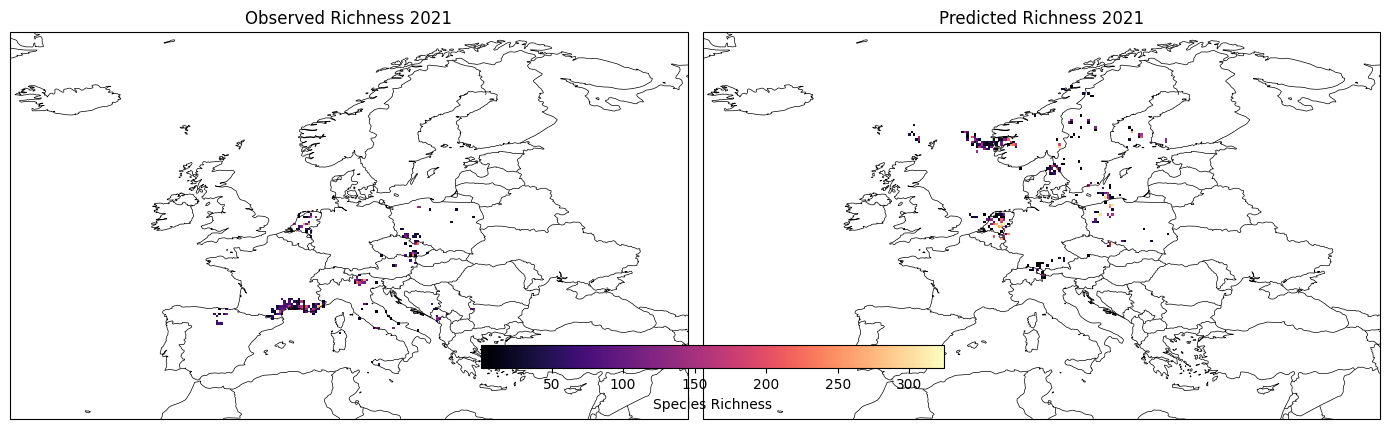

/scratch-local/72884/ipykernel_1038242/1039600842.py:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


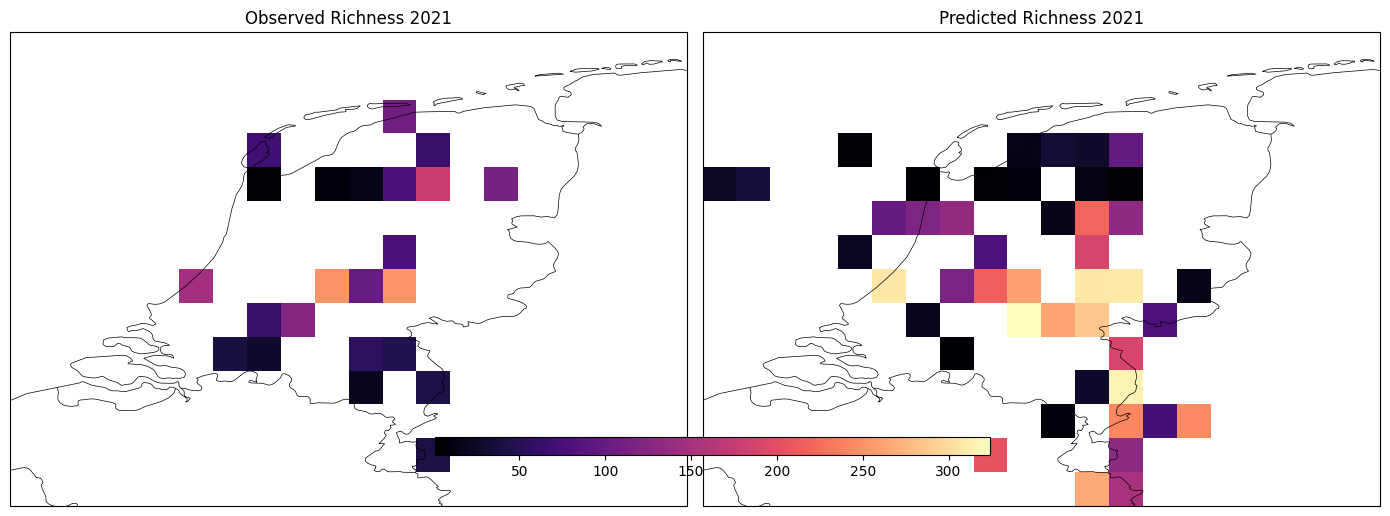

In [27]:
import torch
import matplotlib.pyplot as plt

# pred_tensor and pred_matrix already loaded above
# Read predictions for 2021
pred_path = "/home/tkhan/bfm-finetune/outputs_bfm_finetune_48800/predictions/finetune_predictions.pt"
pred_tensor = torch.load(pred_path, map_location="cpu")

# Compute predicted richness per cell as number of species with prediction > 0.5
pred_matrix = pred_tensor.squeeze().numpy()  # shape: (500, 160, 280)
pred_richness = (pred_matrix > 0.5).sum(axis=0)  # shape: (160, 280)

# Select only 2021 data for observed richness
df_2021 = df[df["year"] == 2021]
lon_idx_2021 = np.searchsorted(lon_edges, df_2021["lon"], side="right") - 1
lat_idx_2021 = np.searchsorted(lat_edges, df_2021["lat"], side="right") - 1
inside_2021 = (lon_idx_2021 >= 0) & (lon_idx_2021 < n_x) & (lat_idx_2021 >= 0) & (lat_idx_2021 < n_y)

cell_key_2021 = lat_idx_2021[inside_2021] * n_x + lon_idx_2021[inside_2021]
richness_2021 = (
    pd.DataFrame({"cell": cell_key_2021, "sp": df_2021["speciesId"].values[inside_2021]})
      .drop_duplicates()
      .groupby("cell").size()
      .reindex(range(n_x * n_y), fill_value=0)
      .values.reshape(n_y, n_x)
)

rich_mask_2021 = np.ma.masked_where(richness_2021 == 0, richness_2021)
pred_rich_mask = np.ma.masked_where(pred_richness == 0, pred_richness)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(projection=proj))

im0 = axs[0].pcolormesh(lon_edges, lat_edges, rich_mask_2021, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[0].set_title("Observed Richness 2021")
axs[0].set_extent(extent, crs=proj)
axs[0].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[0].add_feature(cfeature.BORDERS, linewidth=0.5)

# For prediction, create new edges for 0.25° grid covering 160x280
pred_lat_edges = np.linspace(extent[2], extent[3], 161)  # 160 cells
pred_lon_edges = np.linspace(extent[0], extent[1], 281)  # 280 cells

im1 = axs[1].pcolormesh(pred_lon_edges, pred_lat_edges, pred_rich_mask, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[1].set_title("Predicted Richness 2021")
axs[1].set_extent(extent, crs=proj)
axs[1].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[1].add_feature(cfeature.BORDERS, linewidth=0.5)

fig.colorbar(im1, ax=axs, fraction=0.05, pad=0.07, label="Species Richness", location="bottom")
plt.tight_layout()
plt.show()

nl_extent = (3, 8, 50.5, 54)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(projection=proj))

im0 = axs[0].pcolormesh(lon_edges, lat_edges, rich_mask_2021, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[0].set_title("Observed Richness 2021")
axs[0].set_extent(nl_extent, crs=proj)
axs[0].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[0].add_feature(cfeature.BORDERS, linewidth=0.5)

im1 = axs[1].pcolormesh(pred_lon_edges, pred_lat_edges, pred_rich_mask, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[1].set_title("Predicted Richness 2021")
axs[1].set_extent(nl_extent, crs=proj)
axs[1].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[1].add_feature(cfeature.BORDERS, linewidth=0.5)

fig.colorbar(im1, ax=axs, fraction=0.04, pad=0.02, aspect=30, location="bottom")
plt.tight_layout()
plt.show()



In [5]:
df_selected = df[df["speciesId"] == 6874.0]
df_selected.groupby("year").surveyId.count()
# how many each species every year
# 2017    177
# 2018    247
# 2019    128
# 2020    189
# 2021    183

year
2017    177
2018    247
2019    128
2020    189
2021    183
Name: surveyId, dtype: int64

In [8]:
years = sorted(df_selected["year"].unique().tolist())
all_dfs = []
for year in tqdm(years, desc="years"):
    matrix = aggregate_into_latlon_grid(
        df_selected[df_selected["year"] == year],
        lat_range=lat_range,
        lon_range=lon_range,
        step=step,
    )
    df_grid = unroll_matrix_into_df(
        lat_range=lat_range, lon_range=lon_range, matrix=matrix
    )
    all_dfs.append(df_grid)

if all_dfs:
    final_df = all_dfs[0][["lat", "lon"]]
    for year, df_year in zip(years, all_dfs):
        final_df[year] = df_year["value"]

    fig = plots.plot_df_latlon(df=final_df, value_keys=years, title="speciesId=6874")
    fig.show()

years: 100%|██████████| 5/5 [00:00<00:00, 20.53it/s]


NameError: name 'plots' is not defined

In [16]:
#show distribution of df lat and lon values
final_df.groupby(["lat", "lon"]).count()



2017  2018  2019  2020  2021
lat   lon                                 
34.25 -30.00     1     1     1     1     1
      -29.75     1     1     1     1     1
      -29.50     1     1     1     1     1
      -29.25     1     1     1     1     1
      -29.00     1     1     1     1     1
...            ...   ...   ...   ...   ...
72.00  48.75     1     1     1     1     1
       49.00     1     1     1     1     1
       49.25     1     1     1     1     1
       49.50     1     1     1     1     1
       49.75     1     1     1     1     1

[48640 rows x 5 columns]

## Spatial SDM

/scratch-local/tkhan.14838798/ipykernel_1134554/3464151261.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pred_tensor = torch.load(pred_path, map_location="cpu")
/scra

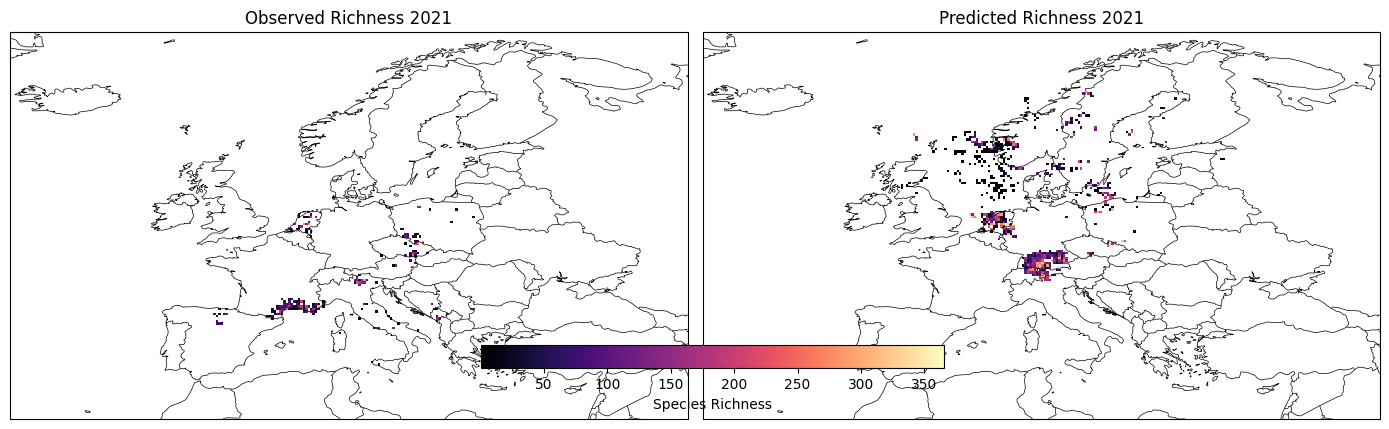

/scratch-local/tkhan.14838798/ipykernel_1134554/3464151261.py:79: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


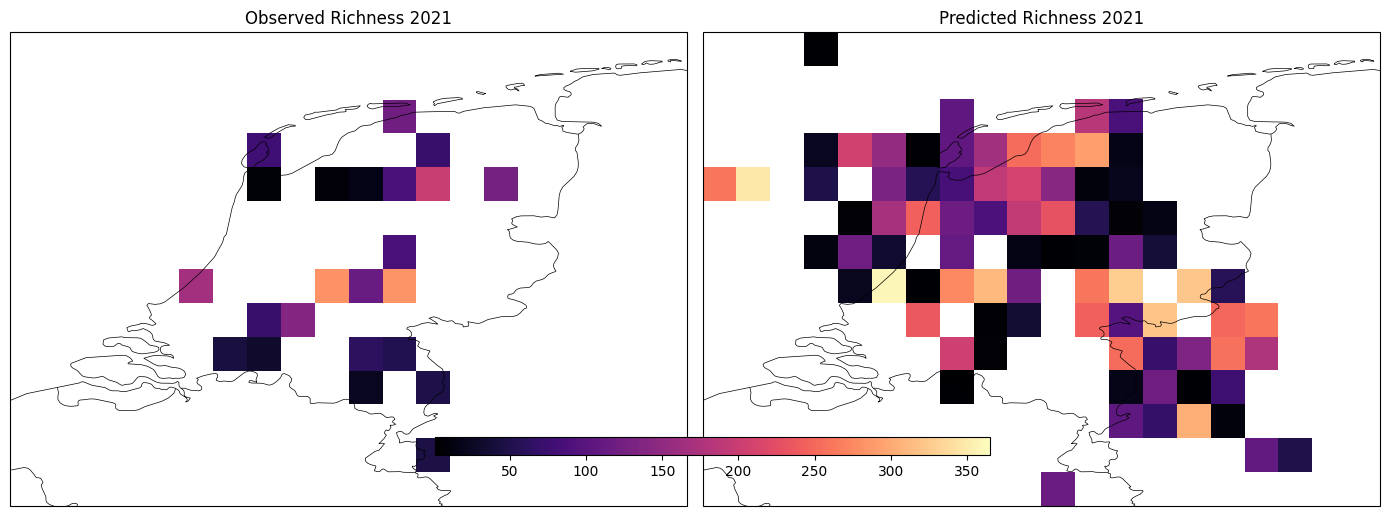

In [13]:
import torch
import matplotlib.pyplot as plt

# Set new extent and grid
extent = (-25.0, 45.0, 32.0, 72.0)   # lon_min, lon_max, lat_min, lat_max
ddeg = 0.25
proj = ccrs.PlateCarree()

lon_edges = np.arange(extent[0], extent[1] + ddeg, ddeg)  # 281 edges, 280 cells
lat_edges = np.arange(extent[2], extent[3] + ddeg, ddeg)  # 161 edges, 160 cells
n_x, n_y = len(lon_edges) - 1, len(lat_edges) - 1   

# pred_tensor and pred_matrix already loaded above
# Read predictions for 2021
pred_path = "/home/tkhan/bfm-finetune/outputs_bfm_spatial/predictions/finetune_predictions.pt"
pred_tensor = torch.load(pred_path, map_location="cpu")

# Compute predicted richness per cell as number of species with prediction > 0.5
pred_matrix = pred_tensor.squeeze().numpy()  # shape: (500, 160, 280)
pred_richness = (pred_matrix > 0.5).sum(axis=0)  # shape: (160, 280)

# Select only 2021 data for observed richness
df_2021 = df[df["year"] == 2021]
lon_idx_2021 = np.searchsorted(lon_edges, df_2021["lon"], side="right") - 1
lat_idx_2021 = np.searchsorted(lat_edges, df_2021["lat"], side="right") - 1
inside_2021 = (lon_idx_2021 >= 0) & (lon_idx_2021 < n_x) & (lat_idx_2021 >= 0) & (lat_idx_2021 < n_y)

cell_key_2021 = lat_idx_2021[inside_2021] * n_x + lon_idx_2021[inside_2021]
richness_2021 = (
    pd.DataFrame({"cell": cell_key_2021, "sp": df_2021["speciesId"].values[inside_2021]})
      .drop_duplicates()
      .groupby("cell").size()
      .reindex(range(n_x * n_y), fill_value=0)
      .values.reshape(n_y, n_x)
)

rich_mask_2021 = np.ma.masked_where(richness_2021 == 0, richness_2021)
pred_rich_mask = np.ma.masked_where(pred_richness == 0, pred_richness)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(projection=proj))

im0 = axs[0].pcolormesh(lon_edges, lat_edges, rich_mask_2021, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[0].set_title("Observed Richness 2021")
axs[0].set_extent(extent, crs=proj)
axs[0].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[0].add_feature(cfeature.BORDERS, linewidth=0.5)

# For prediction, create new edges for 0.25° grid covering 160x280
pred_lat_edges = np.linspace(extent[2], extent[3], 161)  # 160 cells
pred_lon_edges = np.linspace(extent[0], extent[1], 281)  # 280 cells

im1 = axs[1].pcolormesh(pred_lon_edges, pred_lat_edges, pred_rich_mask, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[1].set_title("Predicted Richness 2021")
axs[1].set_extent(extent, crs=proj)
axs[1].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[1].add_feature(cfeature.BORDERS, linewidth=0.5)

fig.colorbar(im1, ax=axs, fraction=0.05, pad=0.07, label="Species Richness", location="bottom")
plt.tight_layout()
plt.show()

nl_extent = (3, 8, 50.5, 54)

fig, axs = plt.subplots(1, 2, figsize=(14, 6), subplot_kw=dict(projection=proj))

im0 = axs[0].pcolormesh(lon_edges, lat_edges, rich_mask_2021, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[0].set_title("Observed Richness 2021")
axs[0].set_extent(nl_extent, crs=proj)
axs[0].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[0].add_feature(cfeature.BORDERS, linewidth=0.5)

im1 = axs[1].pcolormesh(pred_lon_edges, pred_lat_edges, pred_rich_mask, cmap=cmap, vmin=1, shading="auto", transform=proj)
axs[1].set_title("Predicted Richness 2021")
axs[1].set_extent(nl_extent, crs=proj)
axs[1].add_feature(cfeature.COASTLINE, linewidth=0.5)
axs[1].add_feature(cfeature.BORDERS, linewidth=0.5)

fig.colorbar(im1, ax=axs, fraction=0.04, pad=0.02, aspect=30, location="bottom")
plt.tight_layout()
plt.show()



In [22]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point
from pathlib import Path

# --- CONFIG ---
predictions_path = Path("/home/tkhan/bfm-finetune/outputs_bfm_spatial/predictions/patch_level_predictions.pt")
plots_dir = Path("/home/tkhan/bfm-finetune/outputs_bfm_spatial/plots")
files_dir = Path("/home/tkhan/biodt/storage/finetune/geolifeclef24/aurorashape_species/val")  # adjust to your actual data path

# --- LOAD PREDICTIONS ---
patch_preds = torch.load(predictions_path)
species_richness = np.array(species_richness).squeeze()

# --- LOAD COORDINATES ---
patch_coords = []
for pred_file in sorted(files_dir.glob("*.pt")):
    data = torch.load(pred_file, map_location="cpu")
    lon = data["metadata"]["lon"]
    lat = data["metadata"]["lat"]
    patch_coords.append((lon, lat))

# Sanity check
if len(patch_coords) != len(species_richness):
    raise ValueError(f"Mismatch: {len(patch_coords)} coords vs {len(species_richness)} preds")

# Flatten each lon/lat list into a single lon, lat point
flat_coords = []
for coord in patch_coords:
    if isinstance(coord[0], (list, torch.Tensor)) and isinstance(coord[1], (list, torch.Tensor)):
        # Take the mean if it's a sequence
        lon = float(np.mean(coord[0]))
        lat = float(np.mean(coord[1]))
    else:
        lon, lat = float(coord[0]), float(coord[1])
    flat_coords.append((lon, lat))


# --- CREATE GEODATAFRAME ---
gdf = gpd.GeoDataFrame(
    {"richness": species_richness},
    geometry=[Point(lon, lat) for lon, lat in flat_coords],
    crs="EPSG:4326"
)

# --- SAVE GEOJSON ---
geojson_path = plots_dir / "predicted_richness.geojson"
gdf.to_file(geojson_path, driver="GeoJSON")

# --- PLOT STATIC MAP ---
plt.figure(figsize=(10, 6))
gdf.plot(column="richness", cmap="viridis", legend=True, markersize=8)
plt.title("Predicted Species Richness (Patch-Level)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)

plot_path = plots_dir / "predicted_species_richness_map.png"
plt.savefig(plot_path)
plt.show()

print(f"✅ Saved: {geojson_path}")
print(f"🖼️ Map image: {plot_path}")

/scratch-local/tkhan.14838798/ipykernel_1134554/763292152.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch_preds = torch.load(predictions_path)
/scratch-local/tkha

ValueError: Mismatch: 1 coords vs 500 preds